In [400]:
import os
import mailbox
import sys
import pprint
from tqdm import tqdm
from email.parser import Parser
from email.message import Message
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, BertTokenizer
import evaluate
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification, TrainingArguments, Trainer, DistilBertForSequenceClassification, BertModel
import torch
import csv
from bs4 import BeautifulSoup

from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from datasets import load_dataset, Dataset, DatasetDict
import evaluate

import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import metrics
import copy

# from interpretable_nlp.models import Transformer
# from interpretable_nlp.nlp_utils import VOCAB_SIZE
# from interpretable_nlp.predict_utils import predict_sentiment, attribution_fun, attribution_to_html
import spacy

from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization
from captum.attr import visualization as viz

nlp = spacy.load('en_core_web_sm')

In [182]:
def get_mail_body(payload):
    if type(payload) == list:
        if type(payload[0]) == Message:
            return payload[0].as_string()
        return payload[0]
    else:
        return payload

In [183]:
# read the data
mbox_files = ['./data/phishing2.mbox', './data/phishing3.mbox', './data/private-phishing4.mbox', './data/20051114.mbox', './data/20051114.mbox']
all_mail_data = []
valid_email_count = 0
invalid_email_count = 0
for mbox_file in tqdm(mbox_files):
    print("Processing " + mbox_file)
    mbox = mailbox.mbox(mbox_file)
    mail_data = {}
    for key in tqdm(mbox.iterkeys()):
        try:
            message = mbox[key]
            # print("From: " + message['from'])
            # print("********************************************")
            all_mail_data.append({
                'From': message['from'],
                'Subject': message['subject'],
                'Body': get_mail_body(message.get_payload()),
                'Label': 1
            })
            valid_email_count += 1
        except Exception as e:
            invalid_email_count += 1
            # print(e)
            continue  # The message is malformed. Just leave it.  
print(f"Valid e-mails: {valid_email_count}")
print(f"Invalid e-mails: {invalid_email_count}")

  0%|                                                                                                                  | 0/5 [00:00<?, ?it/s]

Processing ./data/phishing2.mbox



0it [00:00, ?it/s]
1it [00:00,  5.50it/s]
376it [00:00, 1650.84it/s]
831it [00:00, 2762.95it/s]
1423it [00:00, 2628.58it/s]
 20%|█████████████████████▏                                                                                    | 1/5 [00:00<00:02,  1.83it/s]

Processing ./data/phishing3.mbox



0it [00:00, ?it/s]
1it [00:00,  5.29it/s]
385it [00:00, 1655.02it/s]
716it [00:00, 2282.92it/s]
1054it [00:00, 2668.36it/s]
1513it [00:00, 3311.21it/s]
2279it [00:00, 3033.70it/s]
 40%|██████████████████████████████████████████▍                                                               | 2/5 [00:01<00:02,  1.50it/s]

Processing ./data/private-phishing4.mbox



0it [00:00, ?it/s]
1it [00:00,  3.20it/s]
633it [00:00, 1983.60it/s]
1267it [00:00, 3330.52it/s]
1769it [00:00, 3847.94it/s]
2265it [00:00, 3793.80it/s]
2716it [00:00, 3595.93it/s]
3124it [00:01, 3558.12it/s]
3534it [00:01, 3031.33it/s]
 60%|███████████████████████████████████████████████████████████████▌                                          | 3/5 [00:02<00:01,  1.12it/s]

Processing ./data/20051114.mbox



0it [00:00, ?it/s]
438it [00:00, 2954.27it/s]
 80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 4/5 [00:02<00:00,  1.66it/s]

Processing ./data/20051114.mbox



0it [00:00, ?it/s]
438it [00:00, 3352.93it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]

Valid e-mails: 7977
Invalid e-mails: 135


In [184]:
# read more phishing emails
edu_p_data = csv.DictReader(open("./data/PhishingEmailData.csv"))
all_edu_email = []
for row in edu_p_data:
    # print(row)
    all_edu_email.append({
        'From': row['Sender_Email '],
        'Subject': row['\ufeffEmail_Subject'],
        'Body': row['Email_Content'],
        'Label': 1
    })

In [185]:
# read clean emails
raw_email_data = []
malformed_clean_emails = 0
clean_emails_count = 0
for dir_path in ['./data/easy_ham/', './data/easy_ham 2/', './data/easy_ham_2/', './data/hard_ham/', './data/hard_ham 2/']:
    for file_name in tqdm(os.listdir(dir_path)):
        if not file_name.startswith("."):
            filepath = dir_path + file_name
            with open(filepath, "r") as f:
                # print(f"Reading {filepath}")
                try:
                    mail_data = f.read()
                    raw_email_data.append(mail_data)
                    clean_emails_count += 1
                except:
                    # print("Error")
                    malformed_clean_emails += 1
                    continue
print(f"Length of raw email data: {len(raw_email_data)}")
print(f"Clean emails count: {clean_emails_count}")
print(f"Malformed clean emails count: {malformed_clean_emails}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 6709.48it/s]

Length of raw email data: 5943
Clean emails count: 5943
Malformed clean emails count: 445


In [186]:
# process emails
clean_emails = []
for mail_data in tqdm(raw_email_data):
    try:
        email = Parser().parsestr(mail_data)
        clean_emails.append({
            'From': email['from'],
            'Subject': email['subject'],
            'Body': get_mail_body(email.get_payload()),
            'Label': 0
        })
    except:
        # malformed message
        continue
len(clean_emails)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5943/5943 [00:00<00:00, 11352.91it/s]


5943

In [187]:
all_email_data = pd.DataFrame(all_mail_data + all_edu_email + clean_emails)

In [188]:
all_email_data.sample(5)

,From,Subject,Body,Label
9107,David Rees <dbr@greenhydrant.com>,Re: [Razor-users] Problem with Razor 2.14 and ...,"On Thu, Sep 05, 2002 at 06:16:57PM -0500, Mike...",0
8565,newscientist <rssfeeds@spamassassin.taint.org>,Female circumcision does not reduce sexual act...,"URL: http://www.newsisfree.com/click/-2,820695...",0
10567,Gary Lawrence Murphy <garym@canada.com>,Re: Goodbye Global Warming,">>>>> ""J"" == Jim Whitehead <ejw@cse.ucsc.edu> ...",0
1040,"""PayPal"" <paypal@email.paypal.com>",Protect Your Account,Content-Type: text/html;\nContent-Transfer-Enc...,1
9689,Lucas Gonze <lgonze@panix.com>,Re: The case for spam,Dan Brickley wrote:\n> Except that thanks to t...,0


In [191]:
all_email_data = all_email_data.drop_duplicates(subset=['Body'])

## Pre-processing

In [193]:
# remove HTML tags
# remove "Content-Type: text/html;\nContent-Transfer-Encoding: quoted-printable"
# remove "\n" "\t"
# remove extra spaces in between words
def clean_email_body(text):
    # remove HTML tags
    html_free_text = BeautifulSoup(text).text
    # remove "Content-Type: text/html;\nContent-Transfer-Encoding: quoted-printable"
    cleaned_text = re.sub('Content-Type: [\w/]+', '', html_free_text)
    cleaned_text = re.sub('Content-Transfer-Encoding: \w+', '', cleaned_text)
    # remove extra spaces in between words
    cleaned_text = re.sub("\s\s+", " ", cleaned_text)
    return cleaned_text

In [194]:
# clean email body
all_email_data['Body'] = all_email_data['Body'].apply(lambda x: clean_email_body(x))

/Users/knightturing/ml_work/pytorch/env/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/knightturing/ml_work/pytorch/env/lib/python3.10/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/var/folders/gg/c_1qbqks74vfktzlk54zz3240000gn/T/ipykernel_65401/318418142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_email_data['Body'] = all_email_data['Body'].apply(l

In [195]:
all_email_data

,From,Subject,Body,Label
0,"""Credit Union"" <acc-validity@ncua.gov>",[*** POSIBLE SPAM***] FCU: Account update,;\n-printable Credit Union is constantly worki...,1
2,"""paypal@email.paypal.com"" <paypal@email.paypal...",Verify Your PayPal� Account,"Dear PayPal,We recently noticed one or more\na...",1
3,"""aw-confirm@eBay.com"" <aw-confirm@eBay.com>",New email address added to your eBay account !,You have added moarteaalba2000@yahoo.com as a...,1
4,paypal@email.paypal.com <paypal@email.paypal.com>,Get Important Reminders with PayPal� Alerts,"Dear PayPal,We recently noticed one or more\na...",1
5,"""Sky Bank "" <sybank@skyfi.com>",Security Center Advisory!,Sky Online Personal Banking Protect Your Accou...,1
...,...,...,...,...
13885,CNET Shopper Mac Edition <Online#3.19816.79-jn...,Our new Memory Configurator makes RAM shopping...,CNET Shopper Newsletter: MAC Edition Shopper ...,0
13887,ZDNet Tech Update Today <Online#3.19660.88-olL...,What to look for in your next smart phone (Tec...,"Tech Update Today VITAL SIGNS FOR JULY 10, 20...",0
13888,"""CNET News.com Investor"" <Online#3.20340.74-k8...","NEWS.COM INVESTOR: Techs gain on Intel, Motoro...",CNET Investor Dispatch Quote LookupEnter symb...,0
13889,ZDNet Tech Update Today <Online#3.20467.ac-q5A...,When search results don't count (Tech Update),"Tech Update Today VITAL SIGNS FOR JULY 18, 20...",0


In [197]:
phishing_email_count = len(all_email_data[all_email_data['Label'] == 1])
safe_email_count = len(all_email_data[all_email_data['Label'] == 0])
print(f"Count\nPhishing: {phishing_email_count}\nSafe:{safe_email_count}")

Count
Phishing: 6664
Safe:3810


In [198]:
all_email_data.to_csv("./email_data.csv")

# Baseline model

In [440]:
baseline_data = pd.read_csv("./email_data.csv", index_col=0).reset_index().drop(columns = ['index'])

In [213]:
phishing_email_count = len(baseline_data[baseline_data['Label'] == 1])
safe_email_count = len(baseline_data[baseline_data['Label'] == 0])
print(f"Count\nPhishing: {phishing_email_count}\nSafe:{safe_email_count}")

Count
Phishing: 6664
Safe:3810


In [214]:
baseline_data = baseline_data.dropna()
baseline_data

,From,Subject,Body,Label
0,"""Credit Union"" <acc-validity@ncua.gov>",[*** POSIBLE SPAM***] FCU: Account update,;\n-printable Credit Union is constantly worki...,1
1,"""paypal@email.paypal.com"" <paypal@email.paypal...",Verify Your PayPal� Account,"Dear PayPal,We recently noticed one or more\na...",1
2,"""aw-confirm@eBay.com"" <aw-confirm@eBay.com>",New email address added to your eBay account !,You have added moarteaalba2000@yahoo.com as a...,1
3,paypal@email.paypal.com <paypal@email.paypal.com>,Get Important Reminders with PayPal� Alerts,"Dear PayPal,We recently noticed one or more\na...",1
4,"""Sky Bank "" <sybank@skyfi.com>",Security Center Advisory!,Sky Online Personal Banking Protect Your Accou...,1
...,...,...,...,...
10469,CNET Shopper Mac Edition <Online#3.19816.79-jn...,Our new Memory Configurator makes RAM shopping...,CNET Shopper Newsletter: MAC Edition Shopper ...,0
10470,ZDNet Tech Update Today <Online#3.19660.88-olL...,What to look for in your next smart phone (Tec...,"Tech Update Today VITAL SIGNS FOR JULY 10, 20...",0
10471,"""CNET News.com Investor"" <Online#3.20340.74-k8...","NEWS.COM INVESTOR: Techs gain on Intel, Motoro...",CNET Investor Dispatch Quote LookupEnter symb...,0
10472,ZDNet Tech Update Today <Online#3.20467.ac-q5A...,When search results don't count (Tech Update),"Tech Update Today VITAL SIGNS FOR JULY 18, 20...",0


In [215]:
X = baseline_data['Body']
y = baseline_data['Label']

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.30, 
                                   shuffle=True)

In [217]:
count_vect = CountVectorizer()

In [218]:
X_train_bow = count_vect.fit_transform(X_train)
X_test_bow = count_vect.transform(X_test)

In [219]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_bow)
X_test_tfidf = tfidf_transformer.transform(X_test_bow)

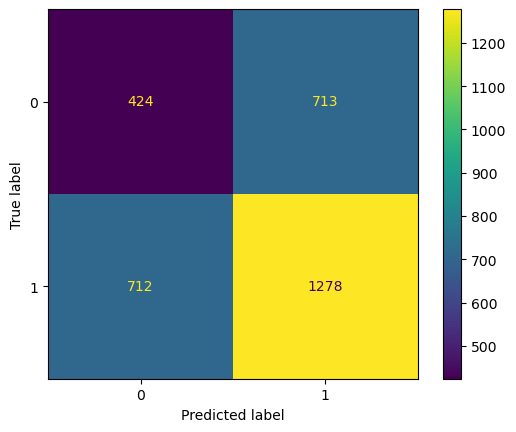

              precision    recall  f1-score   support

           0       0.37      0.37      0.37      1137
           1       0.64      0.64      0.64      1990

    accuracy                           0.54      3127
   macro avg       0.51      0.51      0.51      3127
weighted avg       0.54      0.54      0.54      3127



In [220]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=53)
dummy_clf.fit(X_train_tfidf, y_train)
predictions = dummy_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=dummy_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_clf.classes_)
disp.plot()
plt.show()
print(metrics.classification_report(y_test, predictions, labels=[0, 1]))

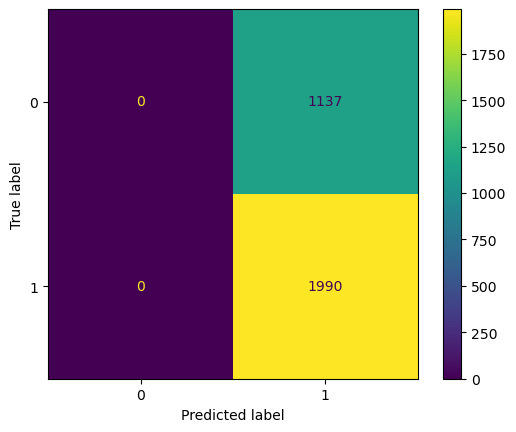

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1137
           1       0.64      1.00      0.78      1990

    accuracy                           0.64      3127
   macro avg       0.32      0.50      0.39      3127
weighted avg       0.40      0.64      0.49      3127



/Users/knightturing/ml_work/pytorch/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/knightturing/ml_work/pytorch/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/knightturing/ml_work/pytorch/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [221]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_tfidf, y_train)
predictions = dummy_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=dummy_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_clf.classes_)
disp.plot()
plt.show()
print(metrics.classification_report(y_test, predictions, labels=[0, 1]))

# Deep learning model

In [441]:
baseline_data = baseline_data.astype(str)
baseline_data['Label'] = baseline_data['Label'].astype(int)

In [442]:
train, test = train_test_split(baseline_data, test_size=0.2)

In [39]:
train_ds = Dataset.from_pandas(train)
test_ds = Dataset.from_pandas(test)

In [324]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [272]:
encodings_train = tokenizer(train_ds['Body'], truncation=True, padding=True)
encodings_test = tokenizer(test_ds['Body'], truncation=True, padding=True)

In [273]:
class PrepareData(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [274]:
train_prepared = PrepareData(encodings_train, train_ds['Label'])
test_prepared = PrepareData(encodings_test, test_ds['Label'])

In [275]:
id2label = {0: "Safe", 1: "Phishing"}
label2id = {"Safe": 0, "Phishing": 1}

In [325]:
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [277]:
if torch.cuda.is_available():
    print(f"CUDA available")
    model = model.to(torch.device("cuda"))
else:
    print(f"CUDA not available")

CUDA not available


In [278]:
accuracy = evaluate.load("accuracy")

In [279]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="phishing_model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_prepared,
    eval_dataset=test_prepared,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

In [47]:
trainer.save_model("./email_dl_model")

In [432]:
# load model
model = AutoModelForSequenceClassification.from_pretrained("./trained_models/phishing_distilebert_model/")

In [459]:
test_predictions = pd.DataFrame(baseline_data.groupby('Label').apply(lambda x: x.sample(min(len(x), 800))).droplevel(0))

In [460]:
phishing_email_count = len(test_predictions[test_predictions['Label'] == 1])
safe_email_count = len(test_predictions[test_predictions['Label'] == 0])
print(f"Count\nPhishing: {phishing_email_count}\nSafe:{safe_email_count}")

Count
Phishing: 800
Safe:800


In [461]:
test_predictions

,From,Subject,Body,Label
7627,Dave Long <dl@silcom.com>,Re: asynchronous I/O (was Re: Gasp!),"> Wrong, [VMS-like async io] makes a huge diff...",0
7778,David Rees <dbr@greenhydrant.com>,[Razor-users] Problem with Razor 2.14 and Spam...,"This is my first time running Razor, heard a l...",0
9035,khare@alumni.caltech.edu,NYTimes.com Article: Why We're So Nice: We're ...,This article from NYTimes.com has been sent to...,0
7076,Alvie <bishop12@prodigy.net>,Re: transcode build problem (was: RH 8 no DMA ...,"On Mon, 2002-10-07 at 11:54, Matthias Saou wro...",0
8139,Robin Hill <robin.hill@baesystems.com>,[zzzzteana] re: Steam,"On Tue, 27 Aug 2002 10:15:36 -0500 (EST)\nJay ...",0
...,...,...,...,...
3109,"""Bank of America""<do-not-reply@bankofamerica.com>",Notification Letter #9260,"Dear Bank Of America Customer, wThiswiswyourw...",1
4487,"""Halifax Bank Plc""<onlinesecurity@halifax.co.uk>",Your Halifax Account Review Department.,\n,1
4769,"""System Administrator""<land@land.series.nom.br>",Your Mailbox Have Exceeded Limit,Your mailbox have exceed the limit of 20MB whi...,1
1196,"""service@intl.paypal.com"" <service@intl.paypal...",Update your account information,PayPal Protect Your Account InfoMake sure you ...,1


In [462]:
test_predictions = test_predictions.dropna()
test_predictions = test_predictions.drop_duplicates(subset=['Body'])
test_predictions

,From,Subject,Body,Label
7627,Dave Long <dl@silcom.com>,Re: asynchronous I/O (was Re: Gasp!),"> Wrong, [VMS-like async io] makes a huge diff...",0
7778,David Rees <dbr@greenhydrant.com>,[Razor-users] Problem with Razor 2.14 and Spam...,"This is my first time running Razor, heard a l...",0
9035,khare@alumni.caltech.edu,NYTimes.com Article: Why We're So Nice: We're ...,This article from NYTimes.com has been sent to...,0
7076,Alvie <bishop12@prodigy.net>,Re: transcode build problem (was: RH 8 no DMA ...,"On Mon, 2002-10-07 at 11:54, Matthias Saou wro...",0
8139,Robin Hill <robin.hill@baesystems.com>,[zzzzteana] re: Steam,"On Tue, 27 Aug 2002 10:15:36 -0500 (EST)\nJay ...",0
...,...,...,...,...
2836,"""Regions bank"" <corporateclients.ref2931512824...",important account notice from Regions Bank!,; Dear business client of Regions Bank:\nThe R...,1
3109,"""Bank of America""<do-not-reply@bankofamerica.com>",Notification Letter #9260,"Dear Bank Of America Customer, wThiswiswyourw...",1
4769,"""System Administrator""<land@land.series.nom.br>",Your Mailbox Have Exceeded Limit,Your mailbox have exceed the limit of 20MB whi...,1
1196,"""service@intl.paypal.com"" <service@intl.paypal...",Update your account information,PayPal Protect Your Account InfoMake sure you ...,1


In [463]:
# inference
all_text = test_predictions['Body'].values.tolist()
all_pred_class_ids = []
all_pred_class_labels = []
for text in tqdm(all_text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
        # print(logits)
    predicted_class_id = logits.argmax().item()
    all_pred_class_ids.append(predicted_class_id)
    all_pred_class_labels.append(model.config.id2label[predicted_class_id])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1562/1562 [01:49<00:00, 14.21it/s]


In [464]:
test_predictions['Predictions'] = all_pred_class_ids

In [465]:
test_predictions['Result'] = test_predictions.apply(lambda x: "Matched" if x['Label'] == x['Predictions'] else "Mismatched", axis=1)

In [519]:
test_predictions[test_predictions['Result'] == 'Matched'].head(10)

,From,Subject,Body,Label,Predictions,Result
7627,Dave Long <dl@silcom.com>,Re: asynchronous I/O (was Re: Gasp!),"> Wrong, [VMS-like async io] makes a huge diff...",0,0,Matched
7778,David Rees <dbr@greenhydrant.com>,[Razor-users] Problem with Razor 2.14 and Spam...,"This is my first time running Razor, heard a l...",0,0,Matched
9035,khare@alumni.caltech.edu,NYTimes.com Article: Why We're So Nice: We're ...,This article from NYTimes.com has been sent to...,0,0,Matched
7076,Alvie <bishop12@prodigy.net>,Re: transcode build problem (was: RH 8 no DMA ...,"On Mon, 2002-10-07 at 11:54, Matthias Saou wro...",0,0,Matched
8139,Robin Hill <robin.hill@baesystems.com>,[zzzzteana] re: Steam,"On Tue, 27 Aug 2002 10:15:36 -0500 (EST)\nJay ...",0,0,Matched
6910,fark <rssfeeds@spamassassin.taint.org>,Congradulate Birthday Boy Putin. Link to send ...,"URL: http://www.newsisfree.com/click/-4,825931...",0,0,Matched
9676,"""Tabor J. Wells"" <razor-users@fsckit.net>",Re: [Razor-users] can't find Razor/Client.pm,"On Tue, Jul 23, 2002 at 06:06:05PM -0400,\nSco...",0,0,Matched
8025,Eugen Leitl <eugen@leitl.org>,Re: Selling Wedded Bliss (was Re: Ouch...),"On Sun, 8 Sep 2002, CDale wrote: > I agree w/ ...",0,0,Matched
7686,"""Geege Schuman"" <geege@barrera.org>",RE: Re[2]: Selling Wedded Bliss (was Re: Ouch...),quitcherbraggin. :-)\ngg -----Original Message...,0,0,Matched
6927,"""wintermute"" <cout@eircom.net>",Re: [ILUG] eircoms adsl modems,It will function as a router if that is what y...,0,0,Matched


In [508]:
# label 0
lab_0_txt_1 = test_predictions.loc[7778]['Body']
lab_0_txt_1

'This is my first time running Razor, heard a lot of good things about it so\nI thought I\'d give it a shot. I also run SpamAssassin so I\'d like to\nintegrate the two. I\'m not sure if this problem is with SpamAssassin or Razor, so I though I\'d\nshoot the message here first With a freshly installed SpamAssassin 2.41 and Razor 2.14 I\'m seeing these\nmessages spit out from spamd: razor2 check skipped: No such file or directory Can\'t call method "log" on\nunblessed reference at /usr/lib/perl5/site_perl/5.6.0/Razor2/Client/Agent.pm\nline 211, line 75. Any ideas? razor seems to run correctly over the command line. Thanks,\n-Dave -------------------------------------------------------\nThis sf.net email is sponsored by: OSDN - Tired of that same old\ncell phone? Get a new here for FREE!\nhttps://www.inphonic.com/r.asp?r=sourceforge1&refcode1=vs3390\n_______________________________________________\nRazor-users mailing list\nRazor-users@lists.sourceforge.net\nhttps://lists.sourceforge.net/

In [521]:
# label 0
lab_0_txt_2 = test_predictions.loc[9676]['Body']
lab_0_txt_2

"On Tue, Jul 23, 2002 at 06:06:05PM -0400,\nScott Henderson is thought to have said: > Thanks, Tabor. How do I install v1 over v2, and where does one\n> get it? (I don't see it at razor.sourceforge.net) It's there. Scroll down on the downloads page. However you might\nconsider going the other way and installing SpamAssassin's 2.40\nbleeding-edge code as Razor v2 has a lot of nice features over v1. -- --------------------------------------------------------------------\nTabor J. Wells razor-users@fsckit.net\nFsck It! Just another victim of the ambient morality -------------------------------------------------------\nThis sf.net email is sponsored by:ThinkGeek\nWelcome to geek heaven.\nhttp://thinkgeek.com/sf\n_______________________________________________\nRazor-users mailing list\nRazor-users@lists.sourceforge.net\nhttps://lists.sourceforge.net/lists/listinfo/razor-users "

In [510]:
# label 1
lab_1_txt_1 = test_predictions.loc[3109]['Body']
lab_1_txt_1

' Dear Bank Of America\xa0Customer, wThiswiswyourwofficialwnotificationwfromwBank Of Americawthatwthewservice(s)wlistedwbelow wwillwbewdeactivatedwandwdeletedwifwnotwrenewedwimmediately.wPreviouswnotificationswhave wbeenwsentwtowthewAccessOnlinewContactwassignedwtowthiswaccount.wAswthewPrimarywContact,wyou wmustwrenewwthewservice(s)wlistedwbelowworwitwwillwbewdeactivatedwandwdeleted.\nRenewwnow wSERVICEw:wBank Of America\xa0AccessOnlineўз. mmEXPIRATION:wSeptember\xa012,w2007 wThankwyou, Bank Of America\xa0OnlinewSupport. w***************************************************************************** wIMPORTANTwCUSTOMERwSUPPORTwINFORMATION w***************************************************************************** Pleasewdownotwreplywtowthiswemail.wThiswmailboxwiswnotwmonitoredwandwyouwwillwnotwreceivewawresponse.wForwassistance,wlogwinwtowyourwBank Of Americawaccountwan dwcho mm TowreceivewemailwnotificationswinwplainwtextwinsteadwofwHTML,wupdatewyourwpreferenceswhere. Bank Of Americ

In [511]:
# label 1
lab_1_txt_2 = test_predictions.loc[1196]['Body']
lab_1_txt_2

'PayPal Protect Your Account InfoMake sure you never provide your password to fraudulent websites.\nTo\nsafely and securely access the PayPal website or your account, you can click in the yellow box, or open a\nnew web browser (e.g. Internet Explorer or Netscape) and type in the\nPayPal URL.\nPayPal will never ask you to enter your password in an email.For more information on protecting yourself from fraud, please review our Security Tips at https://www.paypal.com/row/securitytipsProtect Your PasswordYou should never give your PayPal password to anyone, including PayPal employees. Notification of Limited Account Access As part of our security measures, we regularly screen activity in the PayPal system. We recently noticed the following issue on your account: Unusual account activity has made it necessary to limit account access until additional verification information can be collected. Case ID Number: PP-071-362-996 For your protection, we have limited access to your account until you

In [474]:
true_labels = test_predictions['Label'].values.tolist()
pred_labels = test_predictions['Predictions'].values.tolist()

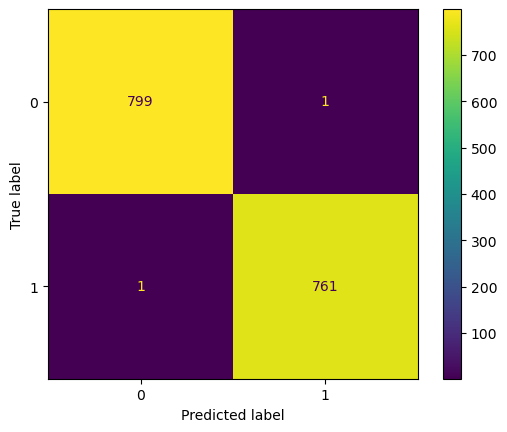

In [477]:
cm = confusion_matrix(true_labels, pred_labels, labels=dummy_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

# Interpreting using Captum

In [327]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    return output.logits

In [328]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # 

In [514]:
def construct_input_ref(text, ref_token_id, sep_token_id, cls_token_id):
    text_ids = tokenizer.encode(text, add_special_tokens=False, truncation=True, padding=True)

    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=torch.device('cpu')), torch.tensor([ref_input_ids], device=torch.device('cpu'))

In [330]:
def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=torch.device('cpu'))
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=torch.device('cpu'))# * -1
    return token_type_ids, ref_token_type_ids

In [331]:
def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=torch.device('cpu'))
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=torch.device('cpu'))

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

In [332]:
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [413]:
def predict(inputs, position_ids=None, attention_mask=None):
    output = model(inputs,
                  attention_mask=attention_mask, )
    return output.logits

In [333]:
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings

In [414]:
def squad_pos_forward_func(inputs, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(0).values.unsqueeze(0)

In [415]:
text = "ear FCU holder account,As part of our security measures, we regularly screen activity in Federal Credit Unions (FCU) network.We recently noticed the following issue on your account: A recent review of your account determined that we require some additional information from you in order to provide you with secure service. Case ID Number: PP-065-617-349 For your protection, we have limited access to your account until additional security measures can be completed. We apologize for any inconvenience this may cause. Please log in to your FCU account to restore your access as soon as possible. You must click the link below and fill in the form on the following page to complete the verification process"
input_ids, ref_input_ids = construct_input_ref(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [416]:
model.eval()
lig = LayerIntegratedGradients(squad_pos_forward_func, model.distilbert.embeddings)
attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                  baselines=ref_input_ids,
                                  additional_forward_args=(position_ids, attention_mask, 0),
                                  return_convergence_delta=True)

In [417]:
start_scores = predict(input_ids)
ground_truth_tokens = tokenizer.encode(text, add_special_tokens=False)
ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1

In [418]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [419]:
attributions_sum = summarize_attributions(attributions_start)

In [420]:
start_position_vis = viz.VisualizationDataRecord(
                        attributions_sum,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        torch.argmax(start_scores),
                        str(ground_truth_start_ind),
                        attributions_sum.sum(),       
                        all_tokens,
                        delta_start)

In [516]:
def calc_and_viz(text):
    input_ids, ref_input_ids = construct_input_ref(text, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    model.eval()
    lig = LayerIntegratedGradients(squad_pos_forward_func, model.distilbert.embeddings)
    attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                  baselines=ref_input_ids,
                                  additional_forward_args=(position_ids, attention_mask, 0),
                                  return_convergence_delta=True)
    start_scores = predict(input_ids)
    ground_truth_tokens = tokenizer.encode(text, add_special_tokens=False, truncation=True, padding=True)
    ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
    ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1
    attributions_sum = summarize_attributions(attributions_start)
    start_position_vis = viz.VisualizationDataRecord(
                        attributions_sum,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        torch.argmax(start_scores),
                        str(ground_truth_start_ind),
                        attributions_sum.sum(),       
                        all_tokens,
                        delta_start)
    return start_position_vis

In [512]:
viz_1 = calc_and_viz(lab_0_txt_1)
print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([viz_1])

 Visualizations For Start Position 


In [522]:
viz_2 = calc_and_viz(lab_0_txt_2)
print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([viz_2])

 Visualizations For Start Position 


In [523]:
viz_3 = calc_and_viz(lab_1_txt_1)
print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([viz_3])

 Visualizations For Start Position 


In [524]:
viz_4 = calc_and_viz(lab_1_txt_2)
print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([viz_4])

 Visualizations For Start Position 
